In [1]:
import numpy as np
import dapy.inference as da
from dapy.models.lorenz63 import Lorenz63Model
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import seaborn as sns
%matplotlib inline
sns.set_style('white')

## Model

Three-dimensional dynamical system due to Lorenz [1] with flow map defined by ODEs

\begin{align}
  \frac{\mathrm{d} z_0}{\mathrm{d} t} &= \sigma (z_1 - z_0) \\
  \frac{\mathrm{d} z_1}{\mathrm{d} t} &= z_0 (\rho - x_2) - z_1 \\
  \frac{\mathrm{d} z_2}{\mathrm{d} t} &= z_0 z_1 - \beta z_2. \\
\end{align}

Here we use the (standard) parameter values $\rho = 28, \sigma=10, \beta=\frac{8}{3}$ which exhibiti chaotic dynamics. An implicit mid-point integrator is used to simulate the dynamics with timestep $dt = 0.005$. Additive Gaussian noise of standard deviation $\sigma_z = 1$ is added to the state every 10<sup>th</sup> timestep and the $z_0$ component of the state is noisily observed every 10<sup>th</sup> timestep with additive Gaussian noise of standard deviation $\sigma_x = 5$.

### References

1. Lorenz, Edward Norton (1963). Deterministic nonperiodic flow. Journal of the Atmospheric Sciences. 20 (2): 130–141.

In [2]:
n_steps = 800
seed = 20171027
rng = np.random.RandomState(seed)
params = {
    'sigma': 10.,
    'rho': 28.,
    'beta': 8. / 3.,
    'init_state_mean': 1.,
    'init_state_std': 0.05,
    'state_noise_std': 1.,
    'observation_func':  lambda z, t: z.T[0:1].T,
    'obser_noise_std': 5.,
    'dt': 0.005,
    'n_steps_per_update': 5,
}
locals().update(params)
model = Lorenz63Model(rng=rng, **params)

## Generate data from model

In [3]:
z_reference, x_reference = model.generate(n_steps)

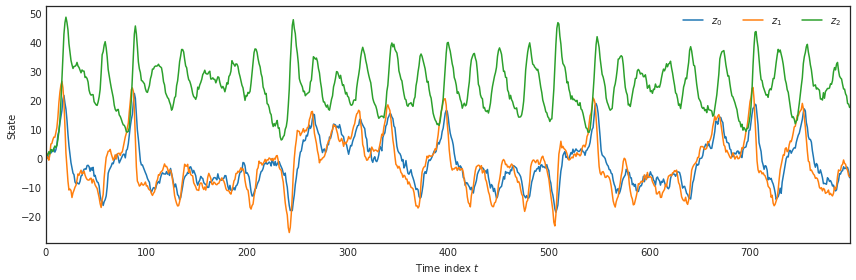

In [4]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(z_reference)
ax.set_xlabel('Time index $t$')
ax.set_ylabel('State')
_ = ax.set_xlim(0, n_steps - 1)
ax.legend(['$z_0$', '$z_1$', '$z_2$'], ncol=3)
fig.tight_layout()

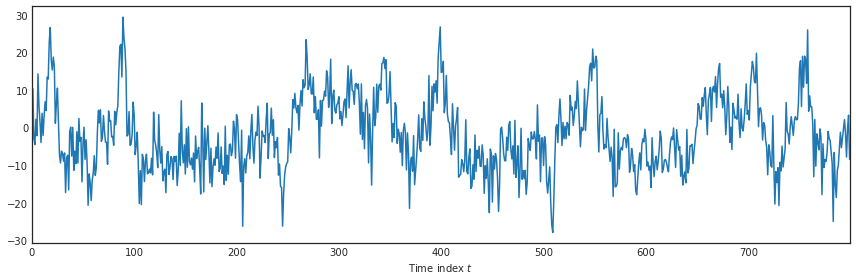

In [5]:
fig = plt.figure(figsize=(12, 4))
ax = fig.add_subplot(1, 1, 1)
ax.plot(x_reference)
ax.set_xlabel('Time index $t$')
_ = ax.set_xlim(0, n_steps - 1)
fig.tight_layout()

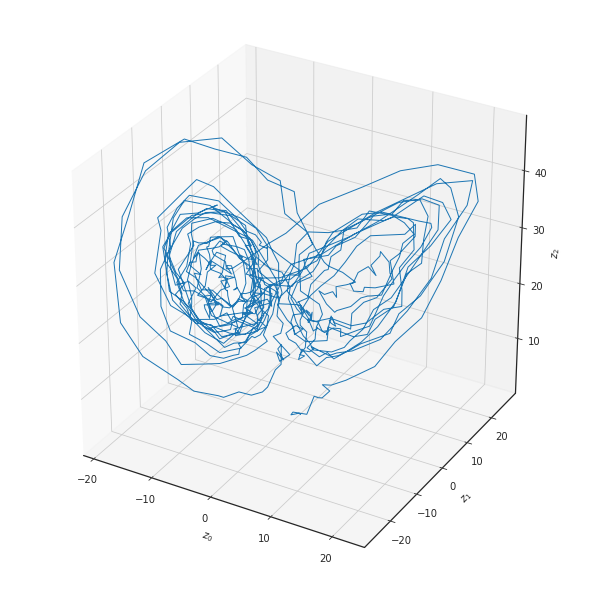

In [6]:
fig = plt.figure(figsize=(8, 8))
ax = Axes3D(fig, [0, 0, 1, 1])
ax.plot(z_reference[:, 0], z_reference[:, 1], z_reference[:, 2], '-', lw=1)
ax.set_xlabel('$z_0$')
ax.set_ylabel('$z_1$')
ax.set_zlabel('$z_2$')

## Infer state from observations

In [7]:
def plot_results(results, z_reference=None, plot_traces=True, plot_region=False, 
                 trace_skip=1, trace_alpha=0.25):
    fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 9))
    for i, ax in zip(range(3), axes):
        ax.plot(results['z_mean_seq'][:, i], 'g-', lw=1)
        if plot_region:
            ax.fill_between(
                np.arange(n_steps),
                results['z_mean_seq'][:, i] - 3 * results['z_std_seq'][:, i],
                results['z_mean_seq'][:, i] + 3 * results['z_std_seq'][:, i],
                alpha=0.25, color='g'
            )
        if plot_traces:
            ax.plot(results['z_particles_seq'][:, ::trace_skip, i], 
                    'r-', lw=0.25, alpha=trace_alpha)
        if z_reference is not None:
            ax.plot(z_reference[:, i], 'k--')
        ax.set_ylabel('$z_{0}$'.format(i))
    ax.set_xlabel('Time index $t$')
    fig.tight_layout()
    return fig, axes

### Ensemble Kalman filter (perturbed observations)

In [8]:
enkf = da.EnsembleKalmanFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_sampler, rng
)

In [9]:
%%time
results_enkf = enkf.filter(x_reference, 100, return_particles=True)

CPU times: user 2.73 s, sys: 108 ms, total: 2.84 s
Wall time: 935 ms


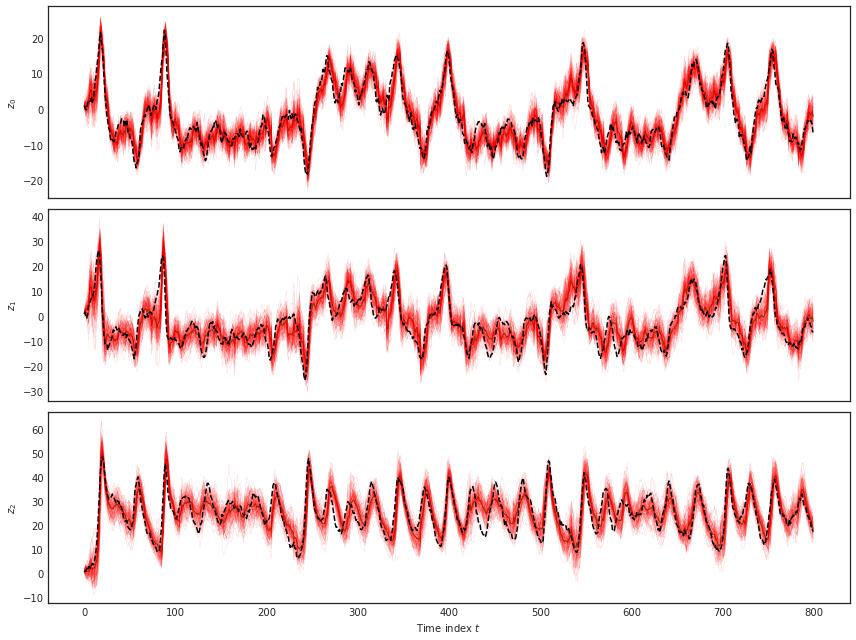

In [10]:
fig, axes = plot_results(results_enkf, z_reference)

### Ensemble Kalman filter (deterministic square root)

In [11]:
esrkf = da.EnsembleSquareRootFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.observation_func, np.array([[model.obser_noise_std]]), rng
)

In [12]:
%%time
results_esrkf = esrkf.filter(x_reference, 100, return_particles=True)

CPU times: user 6.47 s, sys: 308 ms, total: 6.78 s
Wall time: 1.98 s


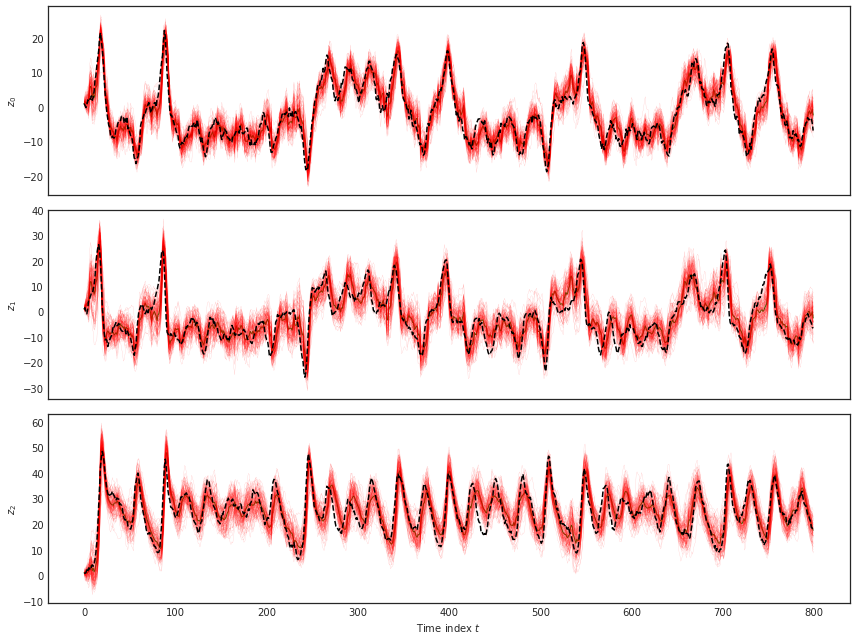

In [13]:
fig, axes = plot_results(results_esrkf, z_reference)

### Bootstrap particle filter

In [14]:
bspf = da.BootstrapParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [15]:
%%time
results_bspf = bspf.filter(x_reference, 100, return_particles=True)

CPU times: user 2.44 s, sys: 112 ms, total: 2.55 s
Wall time: 914 ms


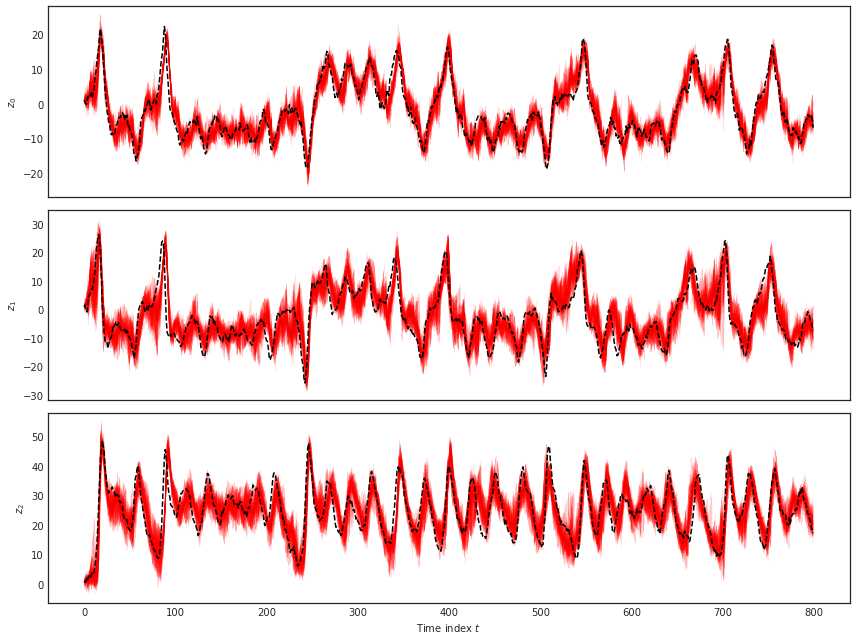

In [16]:
fig, axes = plot_results(results_bspf, z_reference)

### Ensemble transform particle filter

In [17]:
etpf = da.EnsembleTransformParticleFilter(
    model.init_state_sampler, model.next_state_sampler, 
    model.log_prob_dens_obs_gvn_state, rng
)

In [18]:
%%time
results_etpf = etpf.filter(x_reference, 100, return_particles=True)

CPU times: user 8.17 s, sys: 348 ms, total: 8.52 s
Wall time: 2.41 s


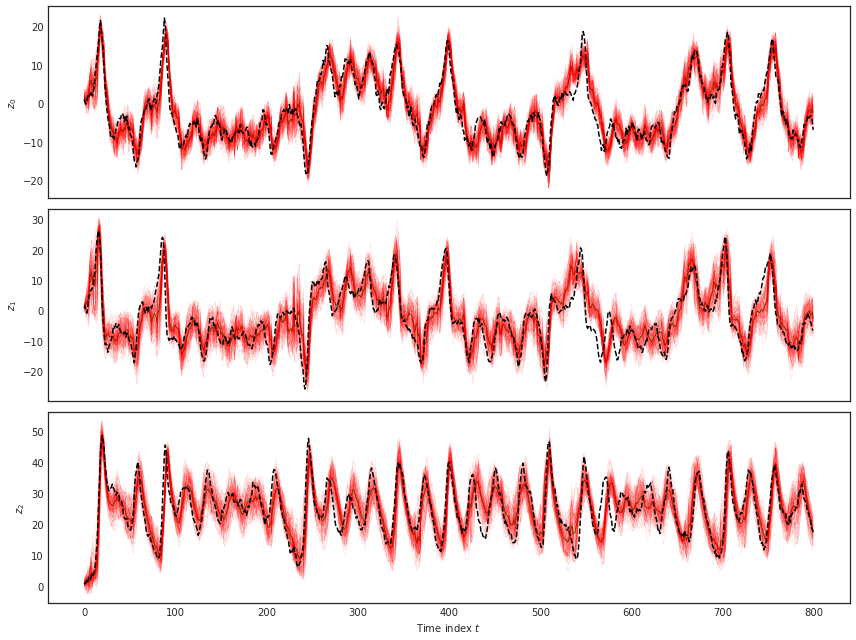

In [19]:
fig, axes = plot_results(results_etpf, z_reference)

### Visualise estimated means of filtering distribution

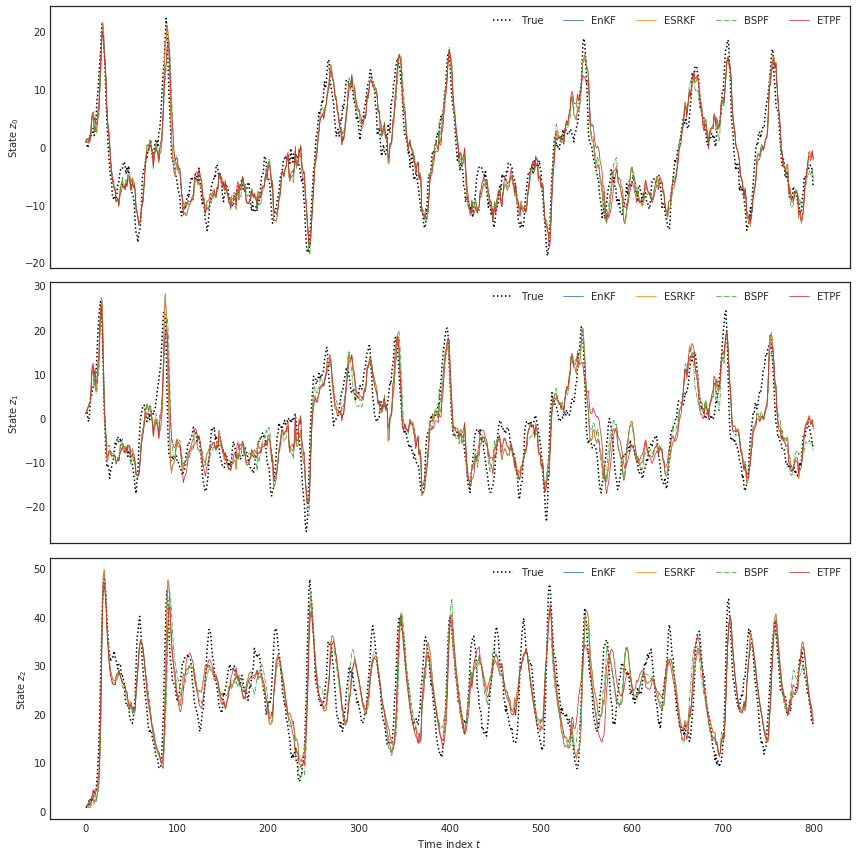

In [20]:
fig, axes = plt.subplots(nrows=3, ncols=1, sharex=True, figsize=(12, 12))
for i, ax in zip(range(3), axes):
    ax.plot(z_reference[:, i], 'k:', label='True')
    ax.plot(results_enkf['z_mean_seq'][:, i], '-', lw=0.75, label='EnKF')
    ax.plot(results_enkf['z_mean_seq'][:, i], '-', lw=0.75, label='ESRKF')
    ax.plot(results_bspf['z_mean_seq'][:, i], '-.', lw=0.75, label='BSPF')
    ax.plot(results_etpf['z_mean_seq'][:, i], '-', lw=0.75, label='ETPF')
    ax.legend(ncol=5)
    ax.set_ylabel('State $z_{0}$'.format(i))
ax.set_xlabel('Time index $t$')
fig.tight_layout()